## Importing the relevant libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, itertools, random
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D, RandomRotation, RandomFlip, RandomZoom, RandomContrast
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import EfficientNetB0
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

100%|██████████| 656M/656M [00:05<00:00, 123MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/versions/5


## Loading the dataset

In [4]:
base_dir = '/root/.cache/kagglehub/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/versions/5/animals/animals'
categories = os.listdir(base_dir)
num_classes = len(categories)
print(f"Total Classes: {num_classes}")

Total Classes: 90


In [5]:
image_paths, labels = [], []

for category in tqdm(os.listdir(base_dir)):
    for img_filepath in os.listdir(os.path.join(base_dir,category)):
        image_path = os.path.join(base_dir,category,img_filepath)
        image_paths.append(image_path)
        labels.append(category)

len(image_paths), len(labels)

  0%|          | 0/90 [00:00<?, ?it/s]

(5400, 5400)

In [6]:
df = pd.DataFrame({'image_filepath': image_paths, 'label': labels})
df.head()

,image_filepath,label
0,/root/.cache/kagglehub/datasets/iamsouravbaner...,caterpillar
1,/root/.cache/kagglehub/datasets/iamsouravbaner...,caterpillar
2,/root/.cache/kagglehub/datasets/iamsouravbaner...,caterpillar
3,/root/.cache/kagglehub/datasets/iamsouravbaner...,caterpillar
4,/root/.cache/kagglehub/datasets/iamsouravbaner...,caterpillar


## Data Exploration

In [7]:
df.shape

(5400, 2)

In [8]:
encoder = LabelEncoder()
df['encoded_label'] = encoder.fit_transform(df['label'])

In [9]:
df.head()

,image_filepath,label,encoded_label
0,/root/.cache/kagglehub/datasets/iamsouravbaner...,caterpillar,10
1,/root/.cache/kagglehub/datasets/iamsouravbaner...,caterpillar,10
2,/root/.cache/kagglehub/datasets/iamsouravbaner...,caterpillar,10
3,/root/.cache/kagglehub/datasets/iamsouravbaner...,caterpillar,10
4,/root/.cache/kagglehub/datasets/iamsouravbaner...,caterpillar,10


In [10]:
# Creating label index mapping
label_idx_mapping = dict()

for idx, label in enumerate(encoder.classes_):
    label_idx_mapping[label] = idx

label_idx_mapping

{'antelope': 0,
 'badger': 1,
 'bat': 2,
 'bear': 3,
 'bee': 4,
 'beetle': 5,
 'bison': 6,
 'boar': 7,
 'butterfly': 8,
 'cat': 9,
 'caterpillar': 10,
 'chimpanzee': 11,
 'cockroach': 12,
 'cow': 13,
 'coyote': 14,
 'crab': 15,
 'crow': 16,
 'deer': 17,
 'dog': 18,
 'dolphin': 19,
 'donkey': 20,
 'dragonfly': 21,
 'duck': 22,
 'eagle': 23,
 'elephant': 24,
 'flamingo': 25,
 'fly': 26,
 'fox': 27,
 'goat': 28,
 'goldfish': 29,
 'goose': 30,
 'gorilla': 31,
 'grasshopper': 32,
 'hamster': 33,
 'hare': 34,
 'hedgehog': 35,
 'hippopotamus': 36,
 'hornbill': 37,
 'horse': 38,
 'hummingbird': 39,
 'hyena': 40,
 'jellyfish': 41,
 'kangaroo': 42,
 'koala': 43,
 'ladybugs': 44,
 'leopard': 45,
 'lion': 46,
 'lizard': 47,
 'lobster': 48,
 'mosquito': 49,
 'moth': 50,
 'mouse': 51,
 'octopus': 52,
 'okapi': 53,
 'orangutan': 54,
 'otter': 55,
 'owl': 56,
 'ox': 57,
 'oyster': 58,
 'panda': 59,
 'parrot': 60,
 'pelecaniformes': 61,
 'penguin': 62,
 'pig': 63,
 'pigeon': 64,
 'porcupine': 65,
 'pos

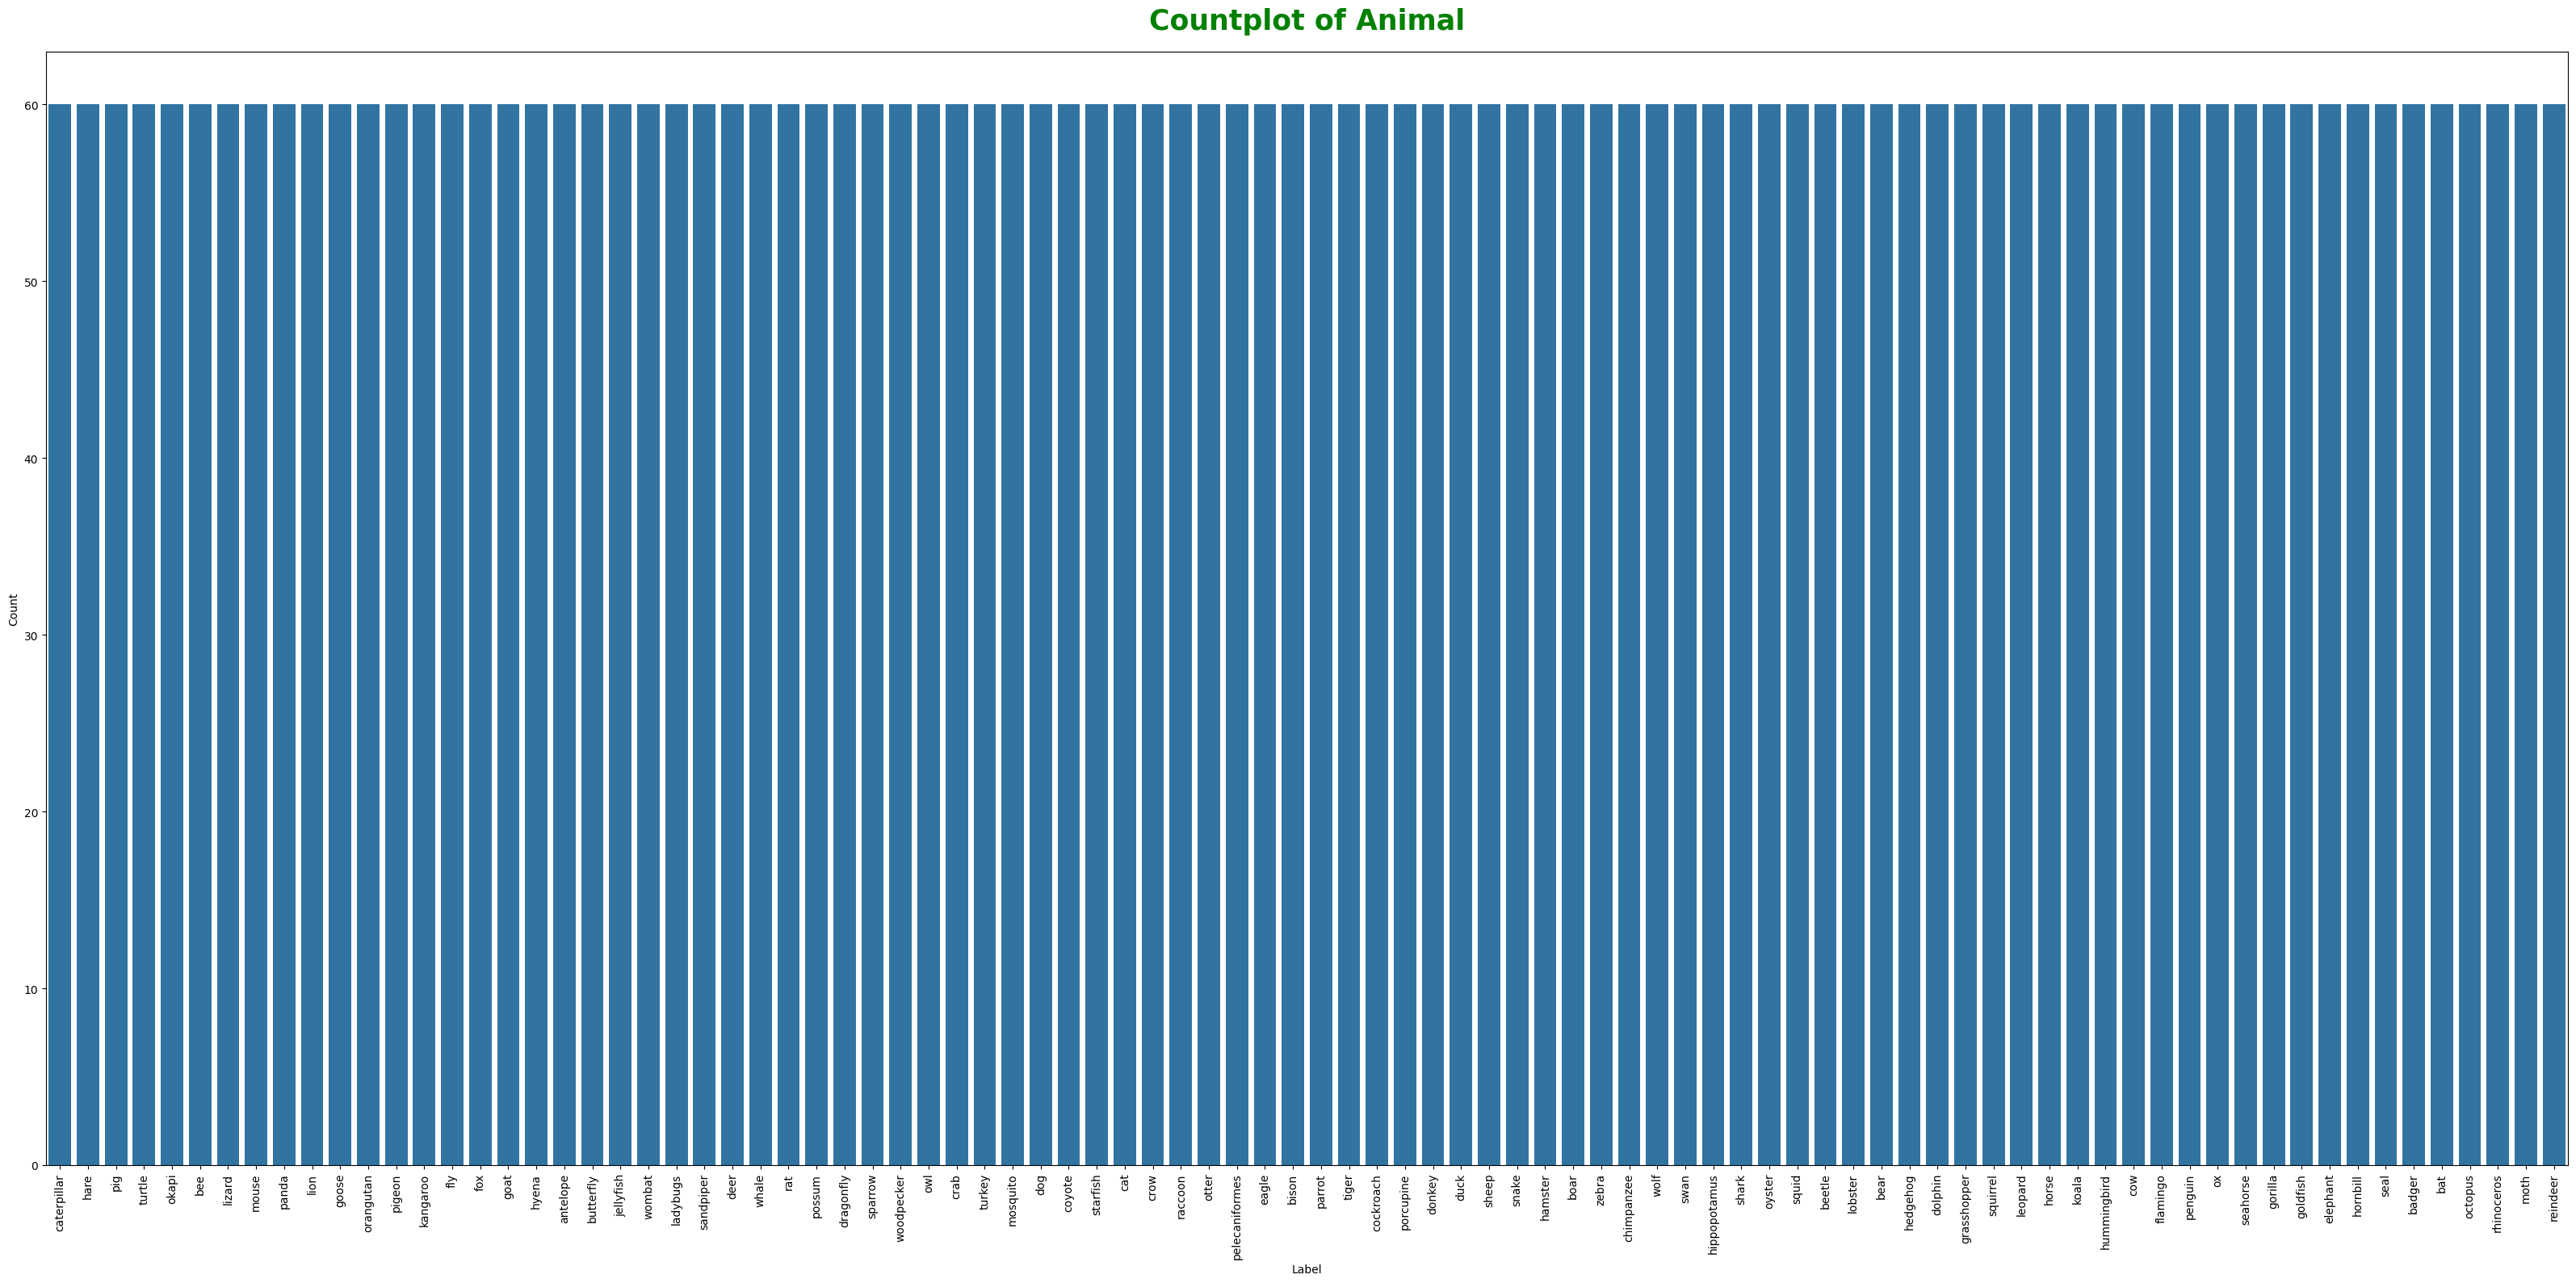

In [11]:
plt.figure(figsize=(32,16))
sns.countplot(data=df,x='label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Countplot of Animal',fontsize=25,pad=20,color='green',fontweight='bold')
plt.tight_layout()
plt.show();

All classes are equally balanced so there won't be imbalanced class problem.

## Performing train-validation-test split

In [12]:
train_df, temp_df = train_test_split(df,train_size=0.7,stratify=df['label'],random_state=101)
val_df, test_df = train_test_split(temp_df,train_size=0.7,stratify=temp_df['label'],random_state=101)

In [13]:
train_df.shape, val_df.shape, test_df.shape

((3779, 3), (1134, 3), (487, 3))

## Creating Image Data Generator objects for train-val-test

In [14]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
generator

In [15]:
train_data_generator = generator.flow_from_dataframe(
    train_df,
    x_col='image_filepath',
    y_col='label',
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE
)

Found 3779 validated image filenames belonging to 90 classes.


In [16]:
val_data_generator = generator.flow_from_dataframe(
    val_df,
    x_col='image_filepath',
    y_col='label',
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE
)

Found 1134 validated image filenames belonging to 90 classes.


In [17]:
test_data_generator = generator.flow_from_dataframe(
    test_df,
    x_col='image_filepath',
    y_col='label',
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE
)

Found 487 validated image filenames belonging to 90 classes.


## Defining the model architecture

In [18]:
n_classes = len(train_data_generator.class_indices)
n_classes

90

In [19]:
# Build EfficientNetB0 model
efficient_net_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='max'
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
# Freeze the layers of the pretrained model
for layer in efficient_net_model.layers:
    layer.trainable = False

In [21]:
# Data Augmentation layer
augment_layer = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
],name='augmentation_layer')

In [22]:
inputs = Input(shape=(224,224,3))
x = augment_layer(inputs)
x = efficient_net_model(x, training=False)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(units=n_classes,activation='softmax')(x)

model = Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_layer (Sequential) │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90)             │        23,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,401,661 (16.79 MB)

 Trainable params: 351,578 (1.34 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

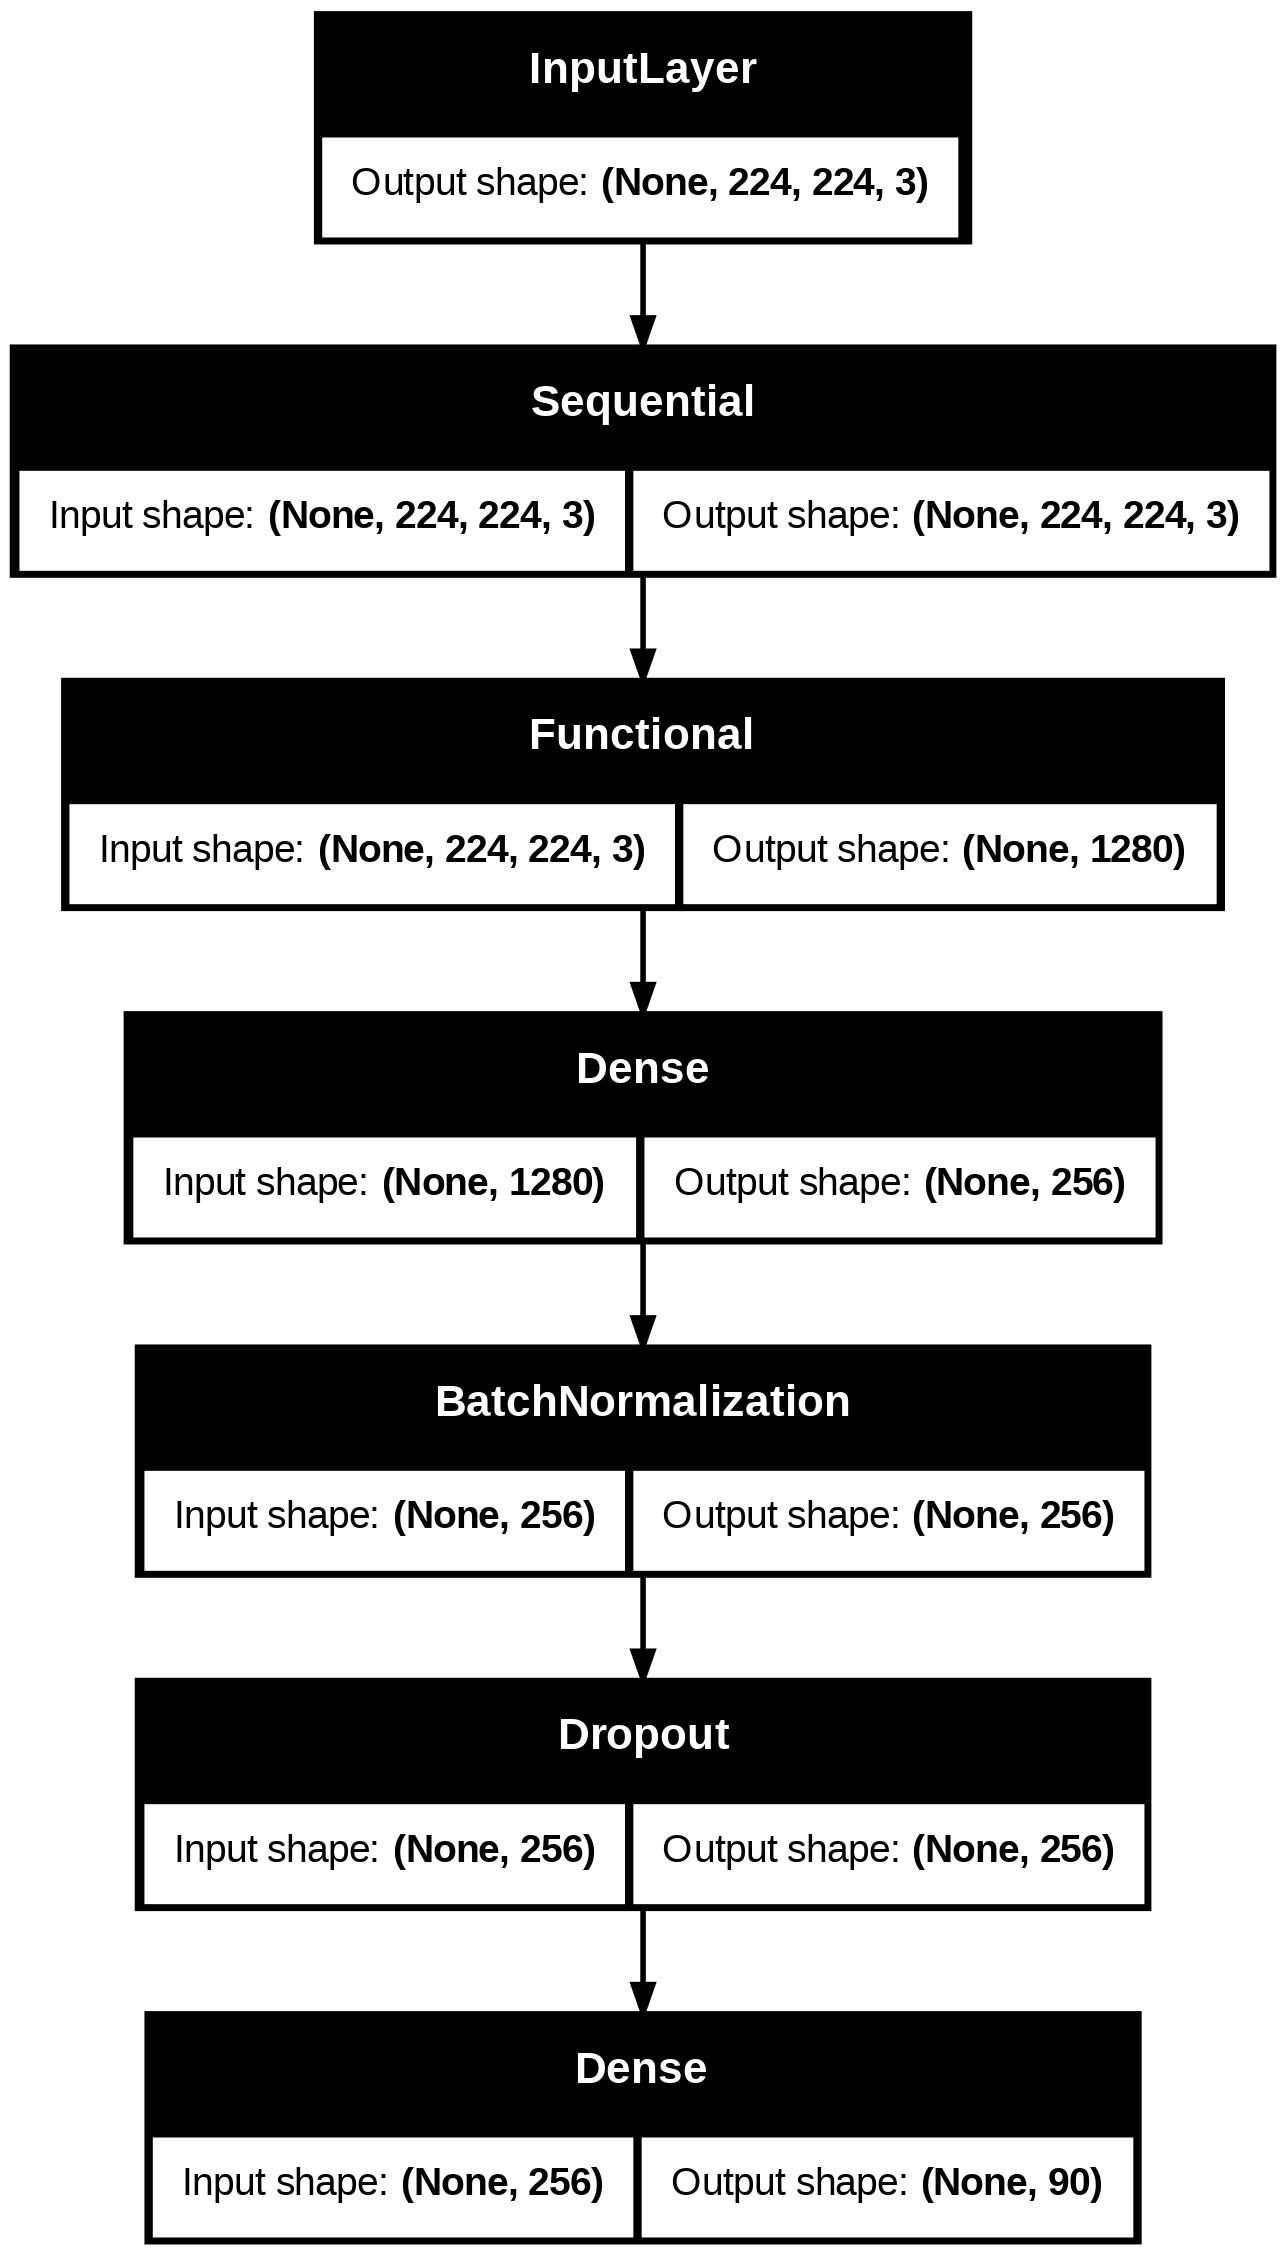

In [23]:
plot_model(model,to_file='model.png',dpi=200,show_shapes=True)

## Model Training - Transfer Learning

In [24]:
# Compile the model
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(learning_rate=5e-4),
             metrics=['accuracy'])

In [25]:
callbacks = [
    EarlyStopping(monitor='val_loss',mode='min',patience=10,verbose=1,restore_best_weights=True,start_from_epoch=5),
    ReduceLROnPlateau(monitor='val_loss',mode='min',factor=0.2,patience=2,verbose=1),
    TensorBoard(log_dir='./',histogram_freq=1,write_graph=True,update_freq='epoch',embeddings_freq=1),
    ModelCheckpoint(filepath='animal_image_classifier.keras',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1,save_freq='epoch')
]

r = model.fit(
    train_data_generator,
    validation_data=val_data_generator,
    epochs=40,
    callbacks=callbacks,
    steps_per_epoch=len(train_data_generator),
    validation_steps=len(val_data_generator),
    verbose=1
)

Epoch 1/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1246 - loss: 4.3406
Epoch 1: val_accuracy improved from -inf to 0.67549, saving model to animal_image_classifier.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 455s 4s/step - accuracy: 0.1257 - loss: 4.3334 - val_accuracy: 0.6755 - val_loss: 1.4287 - learning_rate: 5.0000e-04
Epoch 2/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5557 - loss: 1.9641
Epoch 2: val_accuracy improved from 0.67549 to 0.79453, saving model to animal_image_classifier.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 450s 4s/step - accuracy: 0.5560 - loss: 1.9629 - val_accuracy: 0.7945 - val_loss: 0.8660 - learning_rate: 5.0000e-04
Epoch 3/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7068 - loss: 1.3445
Epoch 3: val_accuracy improved from 0.79453 to 0.82716, saving model to animal_image_classifier.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 507s 4s/step - accuracy: 0.7069 - loss: 1.3439 - val_accuracy: 0.8272 - val_loss: 0.7145 - learning_rate: 5.0000e-04
Epoc

## Visualizing model performance

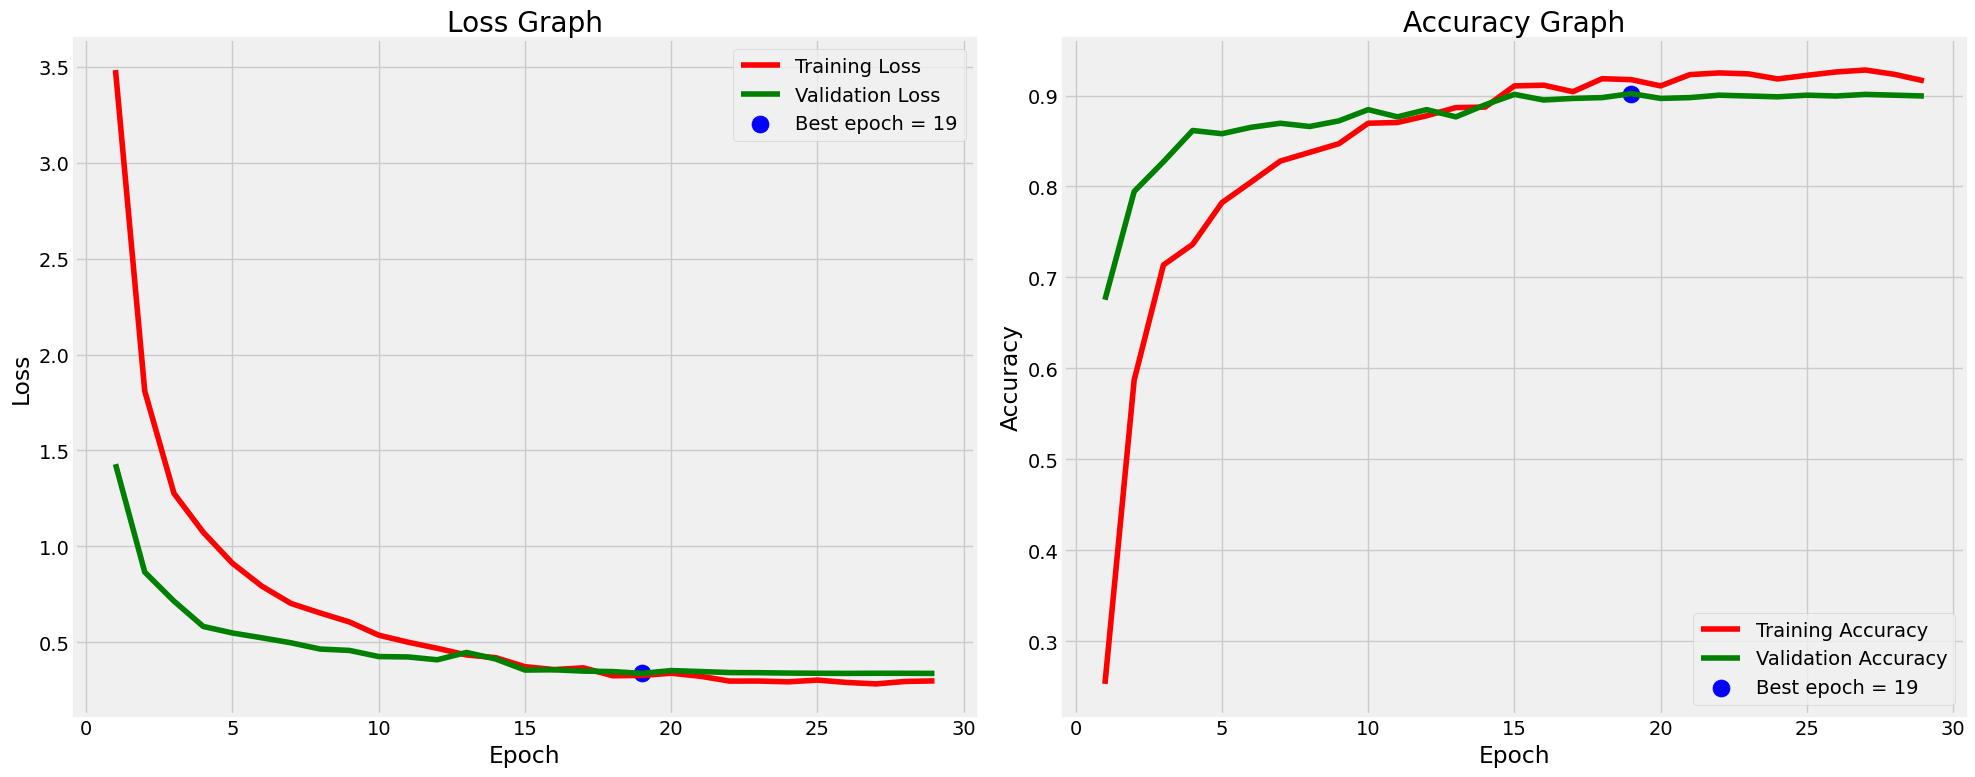

In [26]:
# Extract training details from r.history
train_acc = r.history['accuracy']
train_loss = r.history['loss']
val_acc = r.history['val_accuracy']
val_loss = r.history['val_loss']

# Identify best epoch for loss and accuracy
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# Create epoch index list and labels
epochs = list(range(1, len(train_acc) + 1))
loss_label = f'Best epoch = {index_loss + 1}'
acc_label = f'Best epoch = {index_acc + 1}'

# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

In [28]:
saved_model = model
print(f"Training Accuracy: {r.history['accuracy'][-1]}")
print(f"Validation Accuracy: {r.history['val_accuracy'][-1]}")
print(f"Training Loss: {r.history['loss'][-1]}")
print(f"Validation Loss: {r.history['val_loss'][-1]}")

Training Accuracy: 0.916115403175354
Validation Accuracy: 0.8994709253311157
Training Loss: 0.2987429201602936
Validation Loss: 0.33782491087913513


16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step


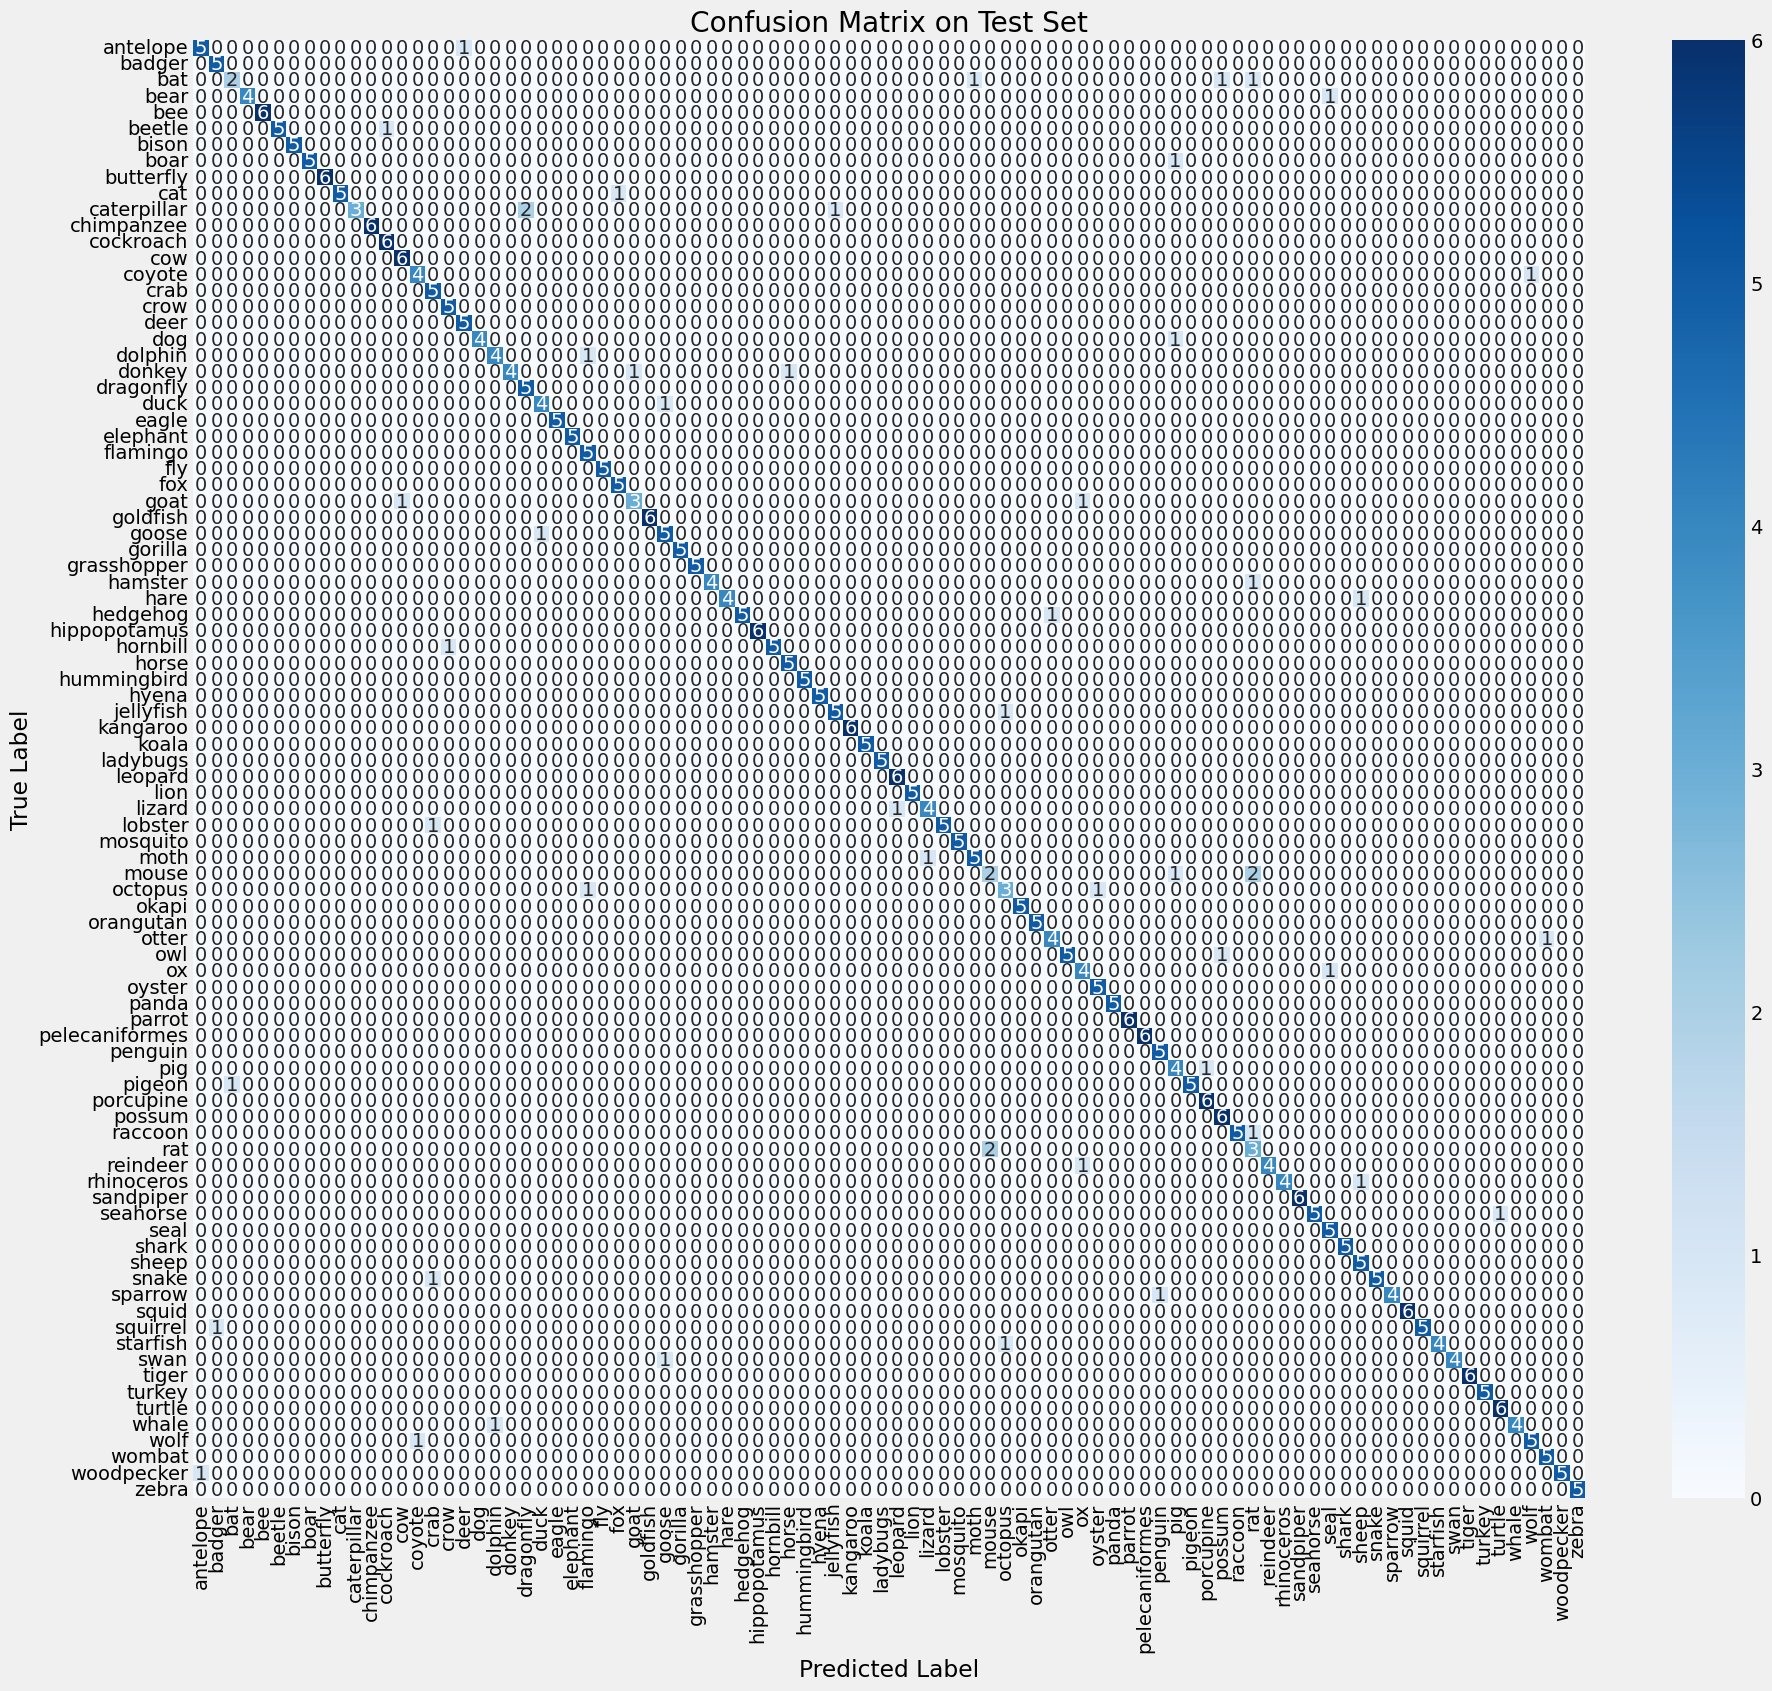

                precision    recall  f1-score   support

      antelope       0.83      0.83      0.83         6
        badger       0.83      1.00      0.91         5
           bat       0.67      0.40      0.50         5
          bear       1.00      0.80      0.89         5
           bee       1.00      1.00      1.00         6
        beetle       1.00      0.83      0.91         6
         bison       1.00      1.00      1.00         5
          boar       1.00      0.83      0.91         6
     butterfly       1.00      1.00      1.00         6
           cat       1.00      0.83      0.91         6
   caterpillar       1.00      0.50      0.67         6
    chimpanzee       1.00      1.00      1.00         6
     cockroach       0.86      1.00      0.92         6
           cow       0.86      1.00      0.92         6
        coyote       0.80      0.80      0.80         5
          crab       0.71      1.00      0.83         5
          crow       0.83      1.00      0.91  

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Get predictions on the test set
test_predictions = saved_model.predict(test_data_generator, verbose=1)
test_predicted_classes = np.argmax(test_predictions, axis=1)
test_true_classes = test_data_generator.classes

# Get the class labels from the test data generator
class_labels = list(test_data_generator.class_indices.keys())

# Compute the confusion matrix
cm = confusion_matrix(test_true_classes, test_predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Print classification report
print(classification_report(test_true_classes, test_predicted_classes, target_names=class_labels))

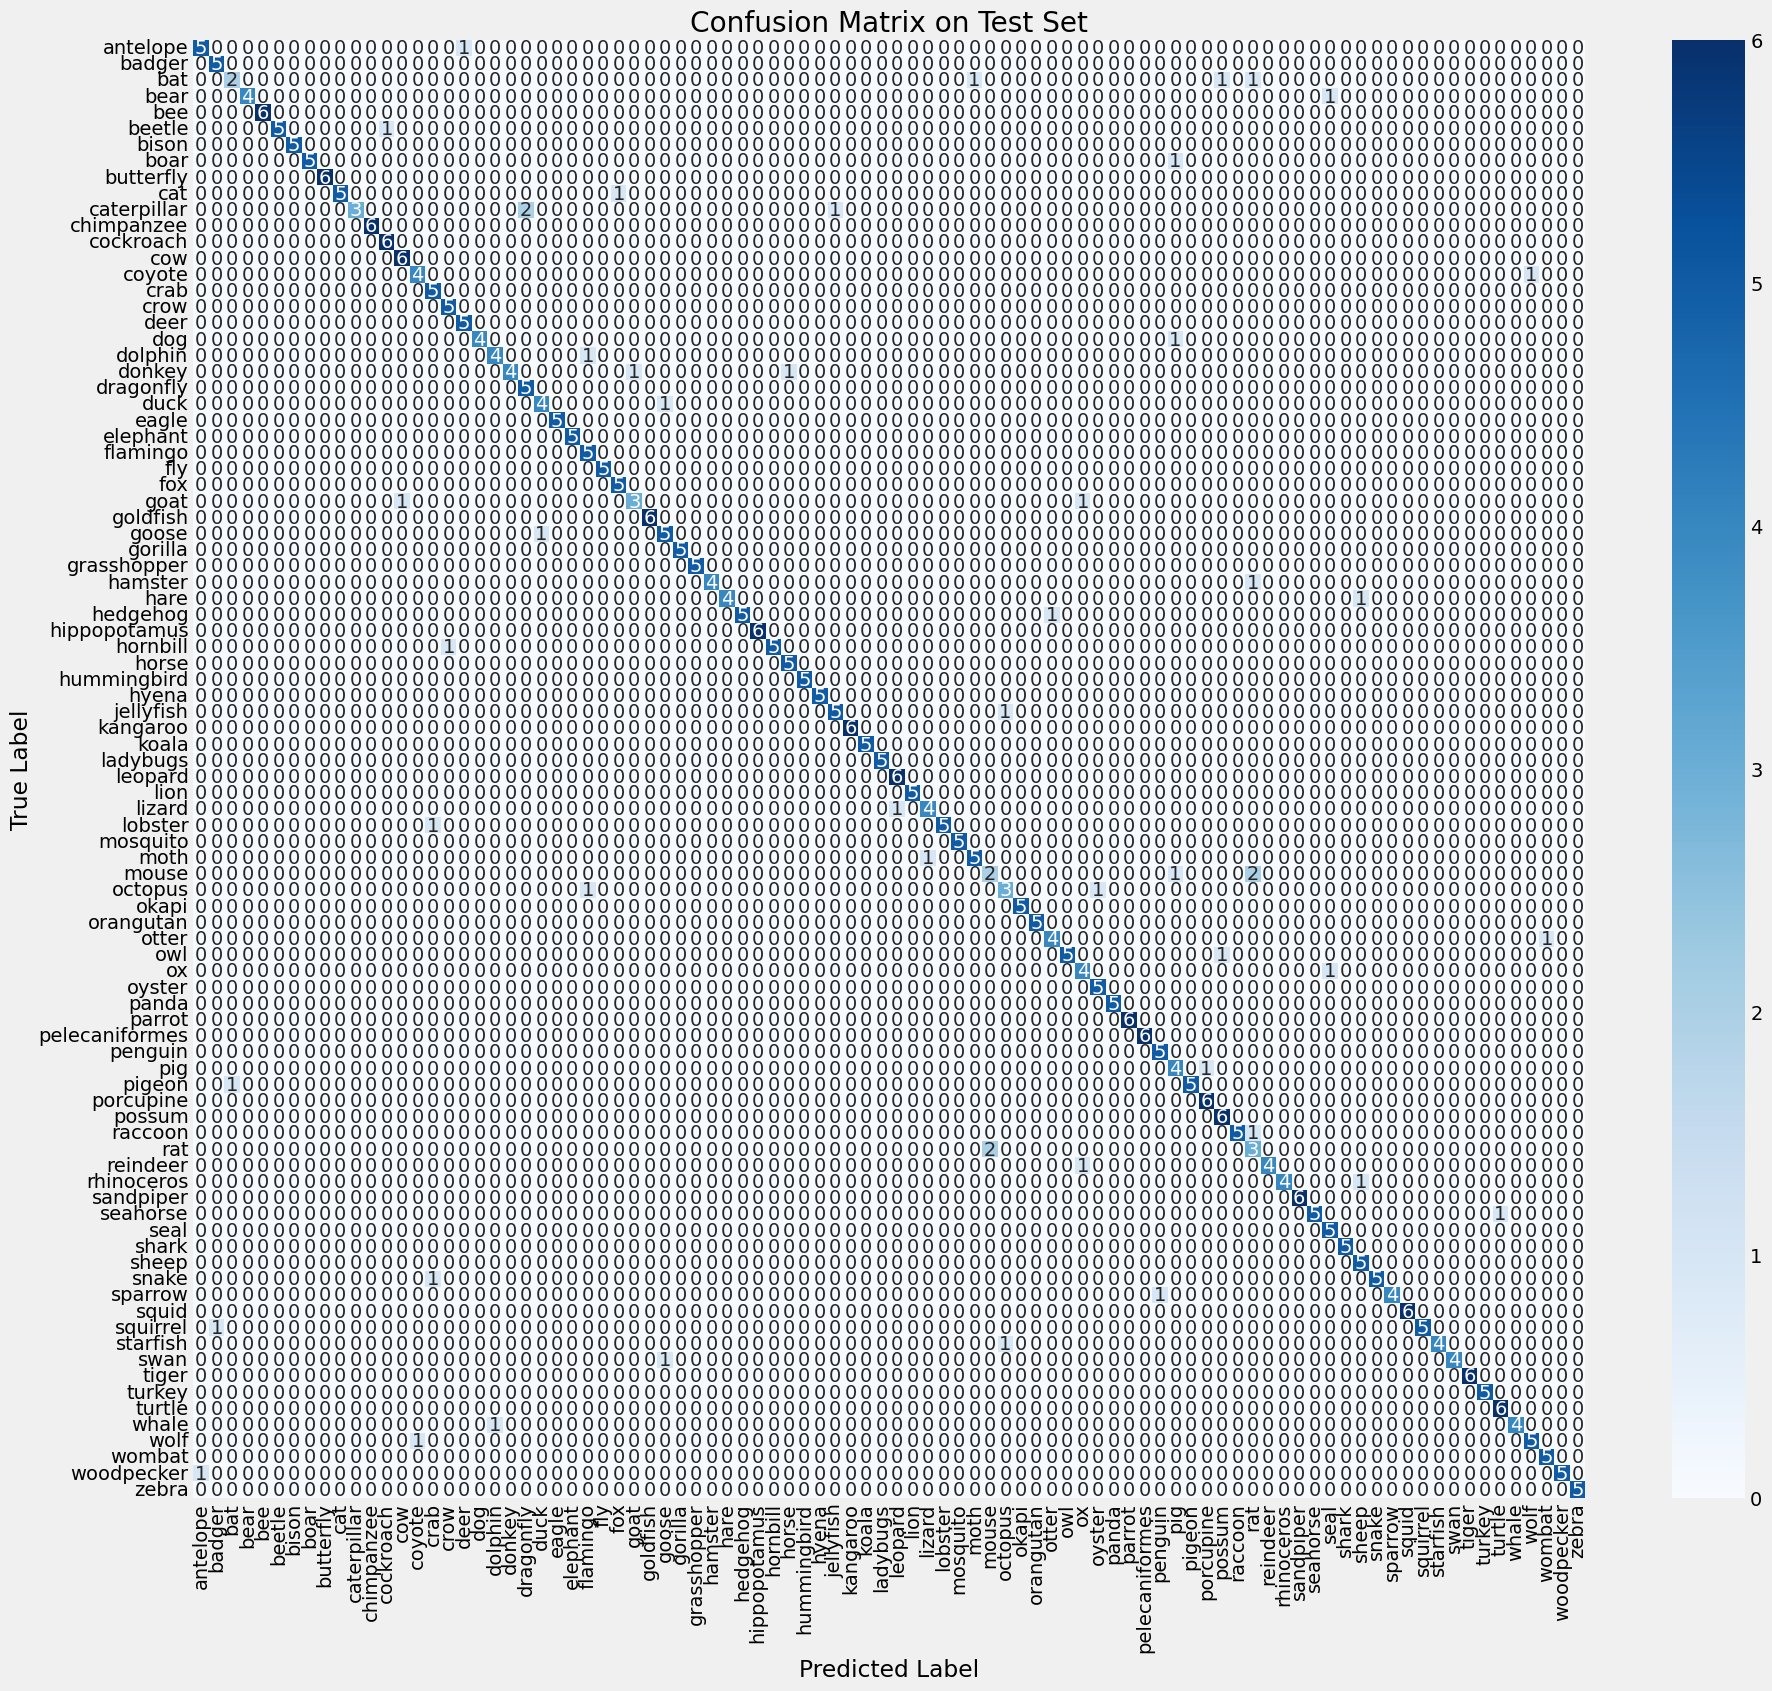

In [30]:
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()